In [ ]:
import torch
from torch import nn
from torch.nn import functional as f
from typing import Literal

In [ ]:
class Attention (nn.Module) :
  def __init__ (self,embed_dim,use_causal_mask = False) :
    super().__init__()
    self.embed_dim = embed_dim
    self.use_causal_mask = use_causal_mask
    self.wq = nn.Linear(embed_dim,embed_dim)
    self.wk = nn.Linear(embed_dim,embed_dim)
    self.wv = nn.Linear(embed_dim,embed_dim)

  def __create_causal_mask (self,S,device) :
    return 1 - torch.tril(torch.ones((S,S),device=device),diagonal=0) * -1e9

  def forward (self,Q,K,V) :
    _,S,_ = Q.shape
    if self.use_causal_mask :
      mask = self.__create_causal_mask(S,Q.device)
    else :
      mask = None
    q = self.wq(Q)
    k = self.wk(K)
    v = self.wv(V)
    score = torch.matmul(q,k.transpose(-2,-1)) / (self.embed_dim ** 0.5)
    if mask is not None :
      score = score + mask
    attn = f.softmax(score,dim=-1)
    outputs = torch.matmul(attn,v)
    return outputs

class LMA (nn.Module) :
  def __init__ (self,embed_dim,use_causal_mask = False,mode : Literal['scaled','kfactor'] = 'scaled',
                factor_init=1e-3) :
    super().__init__()
    self.embed_dim = embed_dim
    self.use_causal_mask = use_causal_mask
    self.mode = mode
    self.wg = nn.Linear(embed_dim,embed_dim)
    self.wo = nn.Linear(embed_dim,embed_dim)
    self.factor = nn.Parameter(
        torch.randn((1,1,embed_dim)) * factor_init
    )

  def __create_causal_mask (self,S,device) :
    return 1 - torch.tril(torch.ones((S,S),device=device),diagonal=0) * -1e9

  def scaled (self,Q,K,V) :
    _,S,_ = Q.shape
    lm = Q + (self.factor * (K + V))
    lm = self.wg(lm)
    score = torch.matmul(lm,K.transpose(-2,-1)) / self.embed_dim **0.5
    if self.use_causal_mask :
      mask = self.__create_causal_mask(S,Q.device)
      score = score + mask
    attn = f.softmax(score,dim=-1)
    outputs = torch.matmul(attn,V)
    outputs = self.wo(outputs)
    return outputs

  def kfactor (self,Q,K,V) :
    lm = Q + (self.factor * K) / self.embed_dim **0.5
    v = self.wg(V)
    score =  f.softmax(lm,dim=-1)
    score = (score * v) + v
    outputs = self.wo(score)
    return outputs

  def forward(self,Q,K,V) :
    if self.mode == 'scaled' :
      return self.scaled(Q,K,V)
    else :
      return self.kfactor(Q,K,V)


In [ ]:
class TransformersBlock (nn.Module) :
  def __init__ (self,embed_dim,drop_rate) :
    super().__init__()
    self.attn = Attention(embed_dim=embed_dim,use_causal_mask=True)
    self.ffn = nn.Sequential(
        nn.Linear(embed_dim,4*embed_dim),
        nn.GELU(approximate='tanh'),
        nn.Linear(embed_dim*4,embed_dim)
    )
    self.drop1 = nn.Dropout(drop_rate)
    self.drop2 = nn.Dropout(drop_rate)
    self.norm1 = nn.RMSNorm(embed_dim)
    self.norm2 = nn.RMSNorm(embed_dim)

  def forward(self,x) :
    z = self.norm1(x)
    attn = self.attn(z,z,z)
    attn = self.drop1(attn)
    x = x + attn

    z = self.norm2(x)
    ffn = self.ffn(z)
    ffn = self.drop2(ffn)
    x = x + ffn

    return x

class TransformersLMABlock (nn.Module) :
  def __init__(self,embed_dim,drop_rate,mode : Literal ['kfactor','scaled'] = 'scaled' ) :
    super().__init__()
    self.attn = LMA(embed_dim=embed_dim,use_causal_mask=True,mode=mode)
    self.ffn = nn.Sequential(
        nn.Linear(embed_dim,4*embed_dim),
        nn.GELU(approximate='tanh'),
        nn.Linear(embed_dim*4,embed_dim)
    )
    self.norm1 = nn.RMSNorm(embed_dim)
    self.norm2  = nn.RMSNorm(embed_dim)
    self.drop1 = nn.Dropout(drop_rate)
    self.drop2 = nn.Dropout(drop_rate)

  def forward(self,x) :
    z = self.norm1(x)
    attn = self.attn(z,z,z)
    attn = self.drop1(attn)
    x = x + attn

    z = self.norm2(x)
    ffn = self.ffn(z)
    ffn = self.drop2(ffn)
    x = x + ffn

    return x

class ClassicTransformers (nn.Module) :
  def __init__(self,vocab_size,embed_dim,num_block,max_poss =100) :
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,embedding_dim=embed_dim)
    self.learned_pos = nn.Embedding(max_poss,embed_dim)
    self.blocks = nn.ModuleList([
        TransformersBlock(embed_dim=embed_dim,drop_rate=0.1) for _ in range(num_block)
    ])
    self.scale = embed_dim **0.5
    self.fo = nn.Linear(embed_dim,vocab_size)

  def forward(self,x) :
    _,s = x.shape
    x = self.embedding(x)
    x = x * self.scale
    pos = torch.arange(s,device=x.device)
    pos = self.learned_pos(pos)
    pos = torch.unsqueeze(pos,dim=0)
    x = x + pos
    for block in self.blocks :
      x = block(x)
    x = self.fo(x)
    return x

class LMATransformers (nn.Module) :
  def __init__(self,vocab_size,embed_dim,num_block,max_poss =100, mode : Literal ['kfactor','scaled']='scaled') :
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,embed_dim)
    self.pos_learn = nn.Embedding(max_poss,embed_dim)
    self.blocks = nn.ModuleList([
        TransformersLMABlock(embed_dim=embed_dim,drop_rate=0.1,mode=mode) for _ in range(num_block)
    ])
    self.scale = embed_dim **0.5
    self.fo = nn.Linear(embed_dim,vocab_size)

  def forward(self,x) :
    _,s = x.shape
    x = self.embedding(x)
    x = x * self.scale
    pos = torch.arange(s,device=x.device)
    pos = self.pos_learn(pos)
    pos = torch.unsqueeze(pos,dim=0)
    x = x + pos
    for block in self.blocks :
      x = block(x)

    x = self.fo(x)
    return x



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kreeshrajani/3k-conversations-dataset-for-chatbot")

print("Path to dataset files:", path)

100%|██████████| 67.1k/67.1k [00:00<00:00, 358kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot/versions/1


In [ ]:
import pandas as pd
df = pd.read_csv(path + '/Conversation.csv')
df

,Unnamed: 0,question,answer
0,0,"hi, how are you doing?",i'm fine. how about yourself?
1,1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,3,no problem. so how have you been?,i've been great. what about you?
4,4,i've been great. what about you?,i've been good. i'm in school right now.
...,...,...,...
3720,3720,that's a good question. maybe it's not old age.,are you right-handed?
3721,3721,are you right-handed?,yes. all my life.
3722,3722,yes. all my life.,you're wearing out your right hand. stop using...
3723,3723,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import DataLoader,Dataset

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.question.to_list())
tokenizer.fit_on_texts(df.answer.to_list())
tokenizer.fit_on_texts(['bos ',' eos'])

In [ ]:
class ChatbotDataset (nn.Module) :
  def __init__(self) :
    super().__init__()
    texts = []
    for i in range(3725) :
      t = df.question[i] + ' ' + df.answer[i]
      texts.append(t)
    self.texts = texts

  def __getitem__(self,idx) :
    x = "bos "+self.texts[idx]
    y = self.texts[idx] + " eos"
    x = tokenizer.texts_to_sequences([x])
    y = tokenizer.texts_to_sequences([y])
    x = pad_sequences(x,maxlen=50,padding='post')[0]
    y = pad_sequences(y,maxlen=50,padding='post')[0]
    return torch.tensor(x),torch.tensor(y,dtype=torch.long)

  def __len__(self) :
    return len(self.texts)


In [ ]:
tokenizer.texts_to_sequences([df.question.to_list()[0]])

[[1522, 36, 14, 2, 174]]

In [ ]:
model =  ClassicTransformers(
    vocab_size=len(tokenizer.word_index)+1,
    embed_dim=256,
    num_block=5
)
model.train(True)
model.to("cuda")
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()


In [ ]:
epochs = 40
loss_record = []

In [ ]:
dataloaded = DataLoader(ChatbotDataset(),batch_size=32,shuffle=True)
from tqdm import tqdm
for epoch in range(epochs) :
  iterator = tqdm(dataloaded)
  losss_total = 0
  for x,y in iterator :
    x = x.to("cuda")
    y = y.to("cuda")
    y_pred = model(x)
    loss = loss_fn(y_pred.view(-1,y_pred.shape[-1]),y.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losss_total += loss.item()
    iterator.set_description(f"epoch {epoch + 1}/{epochs}")
    iterator.set_postfix({"loss" : loss.item()})
  losss_total /= len(dataloaded)
  loss_record.append(losss_total)
  print(f"average_loss : {losss_total}")


epoch 1/20: 100%|██████████| 117/117 [00:02<00:00, 43.82it/s, loss=1.03]


average_loss : 1.1276401123429975


epoch 2/20: 100%|██████████| 117/117 [00:02<00:00, 43.59it/s, loss=0.995]


average_loss : 1.1064712155578482


epoch 3/20: 100%|██████████| 117/117 [00:02<00:00, 48.18it/s, loss=1.1]


average_loss : 1.0879689149367504


epoch 4/20: 100%|██████████| 117/117 [00:02<00:00, 47.87it/s, loss=1.1]


average_loss : 1.0720751514801612


epoch 5/20: 100%|██████████| 117/117 [00:02<00:00, 48.54it/s, loss=1.05]


average_loss : 1.055875428721436


epoch 6/20: 100%|██████████| 117/117 [00:02<00:00, 44.25it/s, loss=0.958]


average_loss : 1.0400124232993166


epoch 7/20: 100%|██████████| 117/117 [00:02<00:00, 43.95it/s, loss=0.874]


average_loss : 1.0243620464944432


epoch 8/20: 100%|██████████| 117/117 [00:02<00:00, 47.04it/s, loss=1.02]


average_loss : 1.01302037993048


epoch 9/20: 100%|██████████| 117/117 [00:02<00:00, 46.81it/s, loss=0.886]


average_loss : 1.000119958168421


epoch 10/20: 100%|██████████| 117/117 [00:02<00:00, 48.20it/s, loss=0.897]


average_loss : 0.9884053952673562


epoch 11/20: 100%|██████████| 117/117 [00:02<00:00, 42.85it/s, loss=0.954]


average_loss : 0.978488861495613


epoch 12/20: 100%|██████████| 117/117 [00:02<00:00, 44.91it/s, loss=0.896]


average_loss : 0.9675846558350784


epoch 13/20: 100%|██████████| 117/117 [00:02<00:00, 47.22it/s, loss=0.86]


average_loss : 0.957135599393111


epoch 14/20: 100%|██████████| 117/117 [00:02<00:00, 46.37it/s, loss=0.968]


average_loss : 0.9475204241581452


epoch 15/20: 100%|██████████| 117/117 [00:03<00:00, 38.52it/s, loss=0.868]


average_loss : 0.9373981152844225


epoch 16/20: 100%|██████████| 117/117 [00:03<00:00, 36.66it/s, loss=0.923]


average_loss : 0.9276745105401064


epoch 17/20: 100%|██████████| 117/117 [00:02<00:00, 47.43it/s, loss=0.852]


average_loss : 0.9185272445026625


epoch 18/20: 100%|██████████| 117/117 [00:02<00:00, 47.62it/s, loss=0.889]


average_loss : 0.9097906646565495


epoch 19/20: 100%|██████████| 117/117 [00:02<00:00, 47.46it/s, loss=0.909]


average_loss : 0.9017685931971949


epoch 20/20: 100%|██████████| 117/117 [00:02<00:00, 43.55it/s, loss=0.839]

average_loss : 0.8930088852205847


In [ ]:
model =  LMATransformers(
    vocab_size=len(tokenizer.word_index) + 1,embed_dim=256,num_block=5,mode='kfactor'
)
model.train(True)
model.to("cuda")
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
epochs = 40
loss_recordLMAKf = []

In [ ]:
dataloaded = DataLoader(ChatbotDataset(),batch_size=32,shuffle=True)
from tqdm import tqdm
for epoch in range(epochs) :
  iterator = tqdm(dataloaded)
  losss_total = 0
  for x,y in iterator :
    x = x.to("cuda")
    y = y.to("cuda")
    y_pred = model(x)
    loss = loss_fn(y_pred.view(-1,y_pred.shape[-1]),y.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losss_total += loss.item()
    iterator.set_description(f"epoch {epoch + 1}/{epochs}")
    iterator.set_postfix({"loss" : loss.item()})
  losss_total /= len(dataloaded)
  loss_recordLMAKf.append(losss_total)
  print(f"average_loss : {losss_total}")


epoch 1/20: 100%|██████████| 117/117 [00:02<00:00, 40.05it/s, loss=1.07]


average_loss : 1.1350402057680309


epoch 2/20: 100%|██████████| 117/117 [00:02<00:00, 49.38it/s, loss=1.3]


average_loss : 1.1190155505115151


epoch 3/20: 100%|██████████| 117/117 [00:02<00:00, 49.47it/s, loss=0.957]


average_loss : 1.1014736289651985


epoch 4/20: 100%|██████████| 117/117 [00:02<00:00, 43.55it/s, loss=1.15]


average_loss : 1.0888609213706775


epoch 5/20: 100%|██████████| 117/117 [00:02<00:00, 49.39it/s, loss=1.07]


average_loss : 1.0743848885226452


epoch 6/20: 100%|██████████| 117/117 [00:02<00:00, 49.53it/s, loss=1]


average_loss : 1.0629034862559066


epoch 7/20: 100%|██████████| 117/117 [00:02<00:00, 48.79it/s, loss=1.29]


average_loss : 1.0536420793614836


epoch 8/20: 100%|██████████| 117/117 [00:02<00:00, 49.50it/s, loss=0.997]


average_loss : 1.0423438121110966


epoch 9/20: 100%|██████████| 117/117 [00:02<00:00, 43.50it/s, loss=0.961]


average_loss : 1.034531670757848


epoch 10/20: 100%|██████████| 117/117 [00:02<00:00, 48.56it/s, loss=0.991]


average_loss : 1.0253330178749867


epoch 11/20: 100%|██████████| 117/117 [00:02<00:00, 48.97it/s, loss=1]


average_loss : 1.0185613876734025


epoch 12/20: 100%|██████████| 117/117 [00:02<00:00, 49.50it/s, loss=0.987]


average_loss : 1.0115197611670208


epoch 13/20: 100%|██████████| 117/117 [00:02<00:00, 48.57it/s, loss=1.06]


average_loss : 1.0057739299586697


epoch 14/20: 100%|██████████| 117/117 [00:02<00:00, 43.93it/s, loss=1.01]


average_loss : 0.9997056773585132


epoch 15/20: 100%|██████████| 117/117 [00:02<00:00, 48.52it/s, loss=1.04]


average_loss : 0.9934165707001319


epoch 16/20: 100%|██████████| 117/117 [00:02<00:00, 48.66it/s, loss=0.991]


average_loss : 0.9888091698670999


epoch 17/20: 100%|██████████| 117/117 [00:02<00:00, 49.44it/s, loss=1.1]


average_loss : 0.9845086636706295


epoch 18/20: 100%|██████████| 117/117 [00:02<00:00, 49.04it/s, loss=0.99]


average_loss : 0.9783109986883962


epoch 19/20: 100%|██████████| 117/117 [00:02<00:00, 44.81it/s, loss=1.26]


average_loss : 0.9745829691234816


epoch 20/20: 100%|██████████| 117/117 [00:02<00:00, 47.95it/s, loss=1.1]

average_loss : 0.9705895730572888


In [ ]:
model =  LMATransformers(
    vocab_size=len(tokenizer.word_index) + 1,embed_dim=256,num_block=5,mode='scaled'
)
model.train(True)
model.to("cuda")
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
epochs = 40
loss_recordLMASL = []

In [ ]:
dataloaded = DataLoader(ChatbotDataset(),batch_size=32,shuffle=True)
from tqdm import tqdm
for epoch in range(epochs) :
  iterator = tqdm(dataloaded)
  losss_total = 0
  for x,y in iterator :
    x = x.to("cuda")
    y = y.to("cuda")
    y_pred = model(x)
    loss = loss_fn(y_pred.view(-1,y_pred.shape[-1]),y.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losss_total += loss.item()
    iterator.set_description(f"epoch {epoch + 1}/{epochs}")
    iterator.set_postfix({"loss" : loss.item()})
  losss_total /= len(dataloaded)
  loss_recordLMASL.append(losss_total)
  print(f"average_loss : {losss_total}")


epoch 1/40: 100%|██████████| 117/117 [00:02<00:00, 47.11it/s, loss=5.57]


average_loss : 8.302791163452671


epoch 2/40: 100%|██████████| 117/117 [00:02<00:00, 49.18it/s, loss=4.25]


average_loss : 4.561985117757422


epoch 3/40: 100%|██████████| 117/117 [00:02<00:00, 43.40it/s, loss=3.99]


average_loss : 3.5848109864781046


epoch 4/40: 100%|██████████| 117/117 [00:02<00:00, 47.24it/s, loss=2.99]


average_loss : 2.98565335966583


epoch 5/40: 100%|██████████| 117/117 [00:02<00:00, 48.67it/s, loss=1.98]


average_loss : 2.582907254879291


epoch 6/40: 100%|██████████| 117/117 [00:02<00:00, 47.95it/s, loss=2.39]


average_loss : 2.2932447459962635


epoch 7/40: 100%|██████████| 117/117 [00:02<00:00, 48.57it/s, loss=1.95]


average_loss : 2.0696405579901147


epoch 8/40: 100%|██████████| 117/117 [00:02<00:00, 41.53it/s, loss=1.76]


average_loss : 1.8950676479910173


epoch 9/40: 100%|██████████| 117/117 [00:02<00:00, 49.09it/s, loss=1.85]


average_loss : 1.7589210159758217


epoch 10/40: 100%|██████████| 117/117 [00:02<00:00, 48.56it/s, loss=1.48]


average_loss : 1.6432299807540371


epoch 11/40: 100%|██████████| 117/117 [00:02<00:00, 48.93it/s, loss=1.6]


average_loss : 1.5534402447887974


epoch 12/40: 100%|██████████| 117/117 [00:02<00:00, 49.13it/s, loss=1.39]


average_loss : 1.476137621789916


epoch 13/40: 100%|██████████| 117/117 [00:02<00:00, 41.62it/s, loss=1.24]


average_loss : 1.4117697772816715


epoch 14/40: 100%|██████████| 117/117 [00:02<00:00, 48.19it/s, loss=1.07]


average_loss : 1.3561274893263466


epoch 15/40: 100%|██████████| 117/117 [00:02<00:00, 48.28it/s, loss=1.34]


average_loss : 1.3090842952076187


epoch 16/40: 100%|██████████| 117/117 [00:02<00:00, 48.54it/s, loss=1.19]


average_loss : 1.2689631657722669


epoch 17/40: 100%|██████████| 117/117 [00:02<00:00, 47.99it/s, loss=1.25]


average_loss : 1.2333319217730792


epoch 18/40: 100%|██████████| 117/117 [00:02<00:00, 41.24it/s, loss=1.13]


average_loss : 1.2000516714193883


epoch 19/40: 100%|██████████| 117/117 [00:02<00:00, 48.39it/s, loss=1.01]


average_loss : 1.1713716897190127


epoch 20/40: 100%|██████████| 117/117 [00:02<00:00, 48.68it/s, loss=1.08]


average_loss : 1.1461895877479489


epoch 21/40: 100%|██████████| 117/117 [00:02<00:00, 48.70it/s, loss=1.16]


average_loss : 1.1226727239087098


epoch 22/40: 100%|██████████| 117/117 [00:02<00:00, 47.19it/s, loss=1.19]


average_loss : 1.1024676342295785


epoch 23/40: 100%|██████████| 117/117 [00:02<00:00, 41.76it/s, loss=1.16]


average_loss : 1.0837204471612587


epoch 24/40: 100%|██████████| 117/117 [00:02<00:00, 47.93it/s, loss=0.983]


average_loss : 1.065003005357889


epoch 25/40: 100%|██████████| 117/117 [00:02<00:00, 48.68it/s, loss=1.03]


average_loss : 1.0511360973374457


epoch 26/40: 100%|██████████| 117/117 [00:02<00:00, 48.59it/s, loss=0.958]


average_loss : 1.0363966445637565


epoch 27/40: 100%|██████████| 117/117 [00:03<00:00, 35.62it/s, loss=1.19]


average_loss : 1.0231248507132897


epoch 28/40: 100%|██████████| 117/117 [00:02<00:00, 43.48it/s, loss=1.09]


average_loss : 1.0112528775492284


epoch 29/40: 100%|██████████| 117/117 [00:02<00:00, 49.11it/s, loss=0.991]


average_loss : 0.9985721895837376


epoch 30/40: 100%|██████████| 117/117 [00:02<00:00, 47.82it/s, loss=1.08]


average_loss : 0.9883404068457775


epoch 31/40: 100%|██████████| 117/117 [00:02<00:00, 48.72it/s, loss=1.01]


average_loss : 0.9766959975927304


epoch 32/40: 100%|██████████| 117/117 [00:02<00:00, 44.62it/s, loss=1.12]


average_loss : 0.9679757906840398


epoch 33/40: 100%|██████████| 117/117 [00:02<00:00, 44.09it/s, loss=0.98]


average_loss : 0.9591225248116714


epoch 34/40: 100%|██████████| 117/117 [00:02<00:00, 48.62it/s, loss=0.797]


average_loss : 0.9502087734703325


epoch 35/40: 100%|██████████| 117/117 [00:02<00:00, 48.24it/s, loss=0.904]


average_loss : 0.9425969938946586


epoch 36/40: 100%|██████████| 117/117 [00:02<00:00, 48.66it/s, loss=1.01]


average_loss : 0.9343567286801134


epoch 37/40: 100%|██████████| 117/117 [00:02<00:00, 44.13it/s, loss=0.935]


average_loss : 0.9276945596067314


epoch 38/40: 100%|██████████| 117/117 [00:02<00:00, 44.91it/s, loss=0.989]


average_loss : 0.920396945415399


epoch 39/40: 100%|██████████| 117/117 [00:02<00:00, 48.54it/s, loss=0.946]


average_loss : 0.912252886682494


epoch 40/40: 100%|██████████| 117/117 [00:02<00:00, 47.79it/s, loss=0.893]

average_loss : 0.9055683587351416


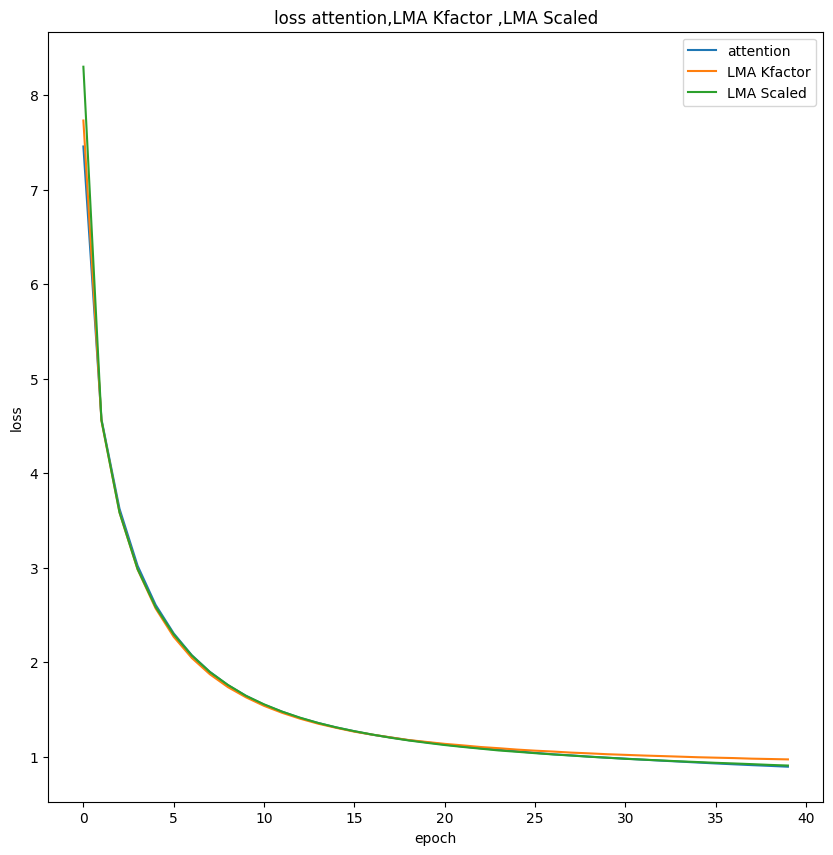

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.title("loss attention,LMA Kfactor ,LMA Scaled")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_record,label="attention")
plt.plot(loss_recordLMAKf,label="LMA Kfactor")
plt.plot(loss_recordLMASL,label="LMA Scaled")
plt.legend()
plt.show()